In [5]:
import os
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import regex as re
from string import punctuation
import math

import nltk
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer #converting text to numerical form
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
import pandas as pd

# Selecting a subset of data to be faster in demonstration
data = pd.read_csv(r'/content/IMDB Dataset.csv')

data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [7]:
data.describe() #418 Duplicates

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


DATA CLEANING

In [8]:
data[data['review'].duplicated() == True]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [9]:
data.drop_duplicates(subset='review', inplace=True)

In [10]:
data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [11]:
def remove_punc(series):
    temp = re.sub(f'[{punctuation}]', '', series)
    temp = re.sub(' br br ','', temp)
    temp = re.sub(' n ','', temp)
    return temp

data['review'] = data['review'].apply(remove_punc)

In [12]:
data[['review']].head()

,review
0,One of the other reviewers has mentioned that ...
1,A wonderful little productionThe filming techn...
2,I thought this was a wonderful way to spend ti...
3,Basically theres a family where a little boy J...
4,Petter Matteis Love in the Time of Money is a ...


In [13]:
def remove_stop(series):
    return ' '.join([x.lower() for x in series.split(' ') if x.lower() not in STOPWORDS])

data['review'] = data['review'].apply(remove_stop)

In [14]:
data[['review']]

,review
0,one reviewers mentioned watching 1 oz episode ...
1,wonderful little productionthe filming techniq...
2,thought wonderful way spend time hot summer we...
3,basically theres family little boy jake thinks...
4,petter matteis love time money visually stunni...
...,...
49995,thought movie right good job wasnt creative or...
49996,bad plot bad dialogue bad acting idiotic direc...
49997,catholic taught parochial elementary schools n...
49998,im going disagree previous comment side maltin...


In [15]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [16]:
def tokenize(series):
    return word_tokenize(series)

data['tokens'] = data['review'].apply(tokenize)

In [17]:
def get_len(series):
    return len(series)

data['token_len'] = data['tokens'].apply(get_len)

In [18]:
data[['tokens','token_len']].head()

,tokens,token_len
0,"[one, reviewers, mentioned, watching, 1, oz, e...",167
1,"[wonderful, little, productionthe, filming, te...",84
2,"[thought, wonderful, way, spend, time, hot, su...",88
3,"[basically, theres, family, little, boy, jake,...",71
4,"[petter, matteis, love, time, money, visually,...",128


In [19]:
data.describe()

,token_len
count,49582.000000
mean,120.074967
std,90.659899
min,3.000000
25%,64.000000
50%,89.000000
75%,146.000000
max,1432.000000


In [20]:
MAX_LEN = math.ceil(data.describe().values[1])
print(MAX_LEN)

121


<ipython-input-20-75024c704cdb>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MAX_LEN = math.ceil(data.describe().values[1])


In [21]:
def pad_token(series):
    if len(series) < MAX_LEN:
        series.extend(['<END>']*(MAX_LEN-len(series)))
        return series
    else:
        return series[:MAX_LEN]

data['paded_tokens'] = data['tokens'].apply(pad_token)

In [22]:
print(data['paded_tokens'].values[10])

['phil', 'alien', 'one', 'quirky', 'films', 'humour', 'based', 'around', 'oddness', 'everything', 'rather', 'actual', 'punchlinesbr', 'br', 'first', 'odd', 'pretty', 'funny', 'movie', 'progressed', 'didnt', 'find', 'jokes', 'oddness', 'funny', 'anymorebr', 'br', 'low', 'budget', 'film', 'thats', 'never', 'problem', 'pretty', 'interesting', 'characters', 'eventually', 'lost', 'interestbr', 'br', 'imagine', 'film', 'appeal', 'stoner', 'currently', 'partakingbr', 'br', 'something', 'similar', 'better', 'try', 'brother', 'another', 'planet', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>

In [23]:
data[['tokens','paded_tokens']]

,tokens,paded_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewers, mentioned, watching, 1, oz, e..."
1,"[wonderful, little, productionthe, filming, te...","[wonderful, little, productionthe, filming, te..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,"[basically, theres, family, little, boy, jake,...","[basically, theres, family, little, boy, jake,..."
4,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movie, right, good, job, wasnt, crea..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,"[catholic, taught, parochial, elementary, scho...","[catholic, taught, parochial, elementary, scho..."
49998,"[im, going, disagree, previous, comment, side,...","[im, going, disagree, previous, comment, side,..."


In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**NORMALAIZATION**

LEMMATAIZATION

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
def lemma(series):
    return [lemmatizer.lemmatize(word) for word in series]

data['lemma_tokens'] = data['paded_tokens'].apply(lemma)

In [27]:
data[['tokens','lemma_tokens']]

,tokens,lemma_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewer, mentioned, watching, 1, oz, ep..."
1,"[wonderful, little, productionthe, filming, te...","[wonderful, little, productionthe, filming, te..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,"[basically, theres, family, little, boy, jake,...","[basically, there, family, little, boy, jake, ..."
4,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movie, right, good, job, wasnt, crea..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,"[catholic, taught, parochial, elementary, scho...","[catholic, taught, parochial, elementary, scho..."
49998,"[im, going, disagree, previous, comment, side,...","[im, going, disagree, previous, comment, side,..."


STEMMING

In [28]:
stemmer = PorterStemmer()

In [29]:
def stem(series):
    return [stemmer.stem(word) for word in series]

data['stem_tokens'] = data['tokens'].apply(stem)

In [30]:
data[['tokens','stem_tokens']]

,tokens,stem_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y..."
1,"[wonderful, little, productionthe, filming, te...","[wonder, littl, productionth, film, techniqu, ..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe..."
3,"[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think..."
4,"[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movi, right, good, job, wasnt, creat..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogu, bad, act, idiot, dir..."
49997,"[catholic, taught, parochial, elementary, scho...","[cathol, taught, parochi, elementari, school, ..."
49998,"[im, going, disagree, previous, comment, side,...","[im, go, disagre, previou, comment, side, malt..."


POS TAGGING

In [31]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
import nltk
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [32]:
def pos_t(series):
    return nltk.pos_tag(series, tagset='universal')

data['pos_tag_tokens'] = data['tokens'].apply(pos_t)


In [33]:
data[['tokens','pos_tag_tokens']]

,tokens,pos_tag_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[(one, NUM), (reviewers, NOUN), (mentioned, VE..."
1,"[wonderful, little, productionthe, filming, te...","[(wonderful, ADJ), (little, ADJ), (productiont..."
2,"[thought, wonderful, way, spend, time, hot, su...","[(thought, VERB), (wonderful, ADJ), (way, NOUN..."
3,"[basically, theres, family, little, boy, jake,...","[(basically, ADV), (theres, NOUN), (family, NO..."
4,"[petter, matteis, love, time, money, visually,...","[(petter, NOUN), (matteis, ADV), (love, ADJ), ..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[(thought, VERB), (movie, NOUN), (right, ADV),..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[(bad, ADJ), (plot, NOUN), (bad, ADJ), (dialog..."
49997,"[catholic, taught, parochial, elementary, scho...","[(catholic, ADJ), (taught, VERB), (parochial, ..."
49998,"[im, going, disagree, previous, comment, side,...","[(im, NOUN), (going, VERB), (disagree, ADJ), (..."


WORD EMBEDDING


In [34]:
unique_words = set()
for tokens in list(data['lemma_tokens'].values):
    unique_words.update(tokens)

In [35]:
print('Count of Unique words:', len(unique_words))

Count of Unique words: 148589


In [36]:
word2idx = {}
for word in unique_words:
    word2idx[word] = len(word2idx)
word2idx['<END>'] = len(word2idx)

In [37]:
word_embeddings = np.random.rand(len(word2idx),200)
with open('/content/glove.6B.100d.txt', 'r') as embeds:
    embeddings = embeds.read()
    embeddings = embeddings.split('\n')[:-2]

for token_idx, token_embed in enumerate(embeddings):
    token = token_embed.split()[0]
    if token in word2idx:
        word_embeddings[word2idx[token]] = [float(val) for val in token_embed.split()[1:]]

FileNotFoundError: [Errno 2] No such file or directory: '/content/glove.6B.100d.txt'

In [ ]:
print(f'Word embeddings for word {list(word2idx.keys())[300]}:',word_embeddings[300])

VECTORIZATION


In [38]:
vectorizer = CountVectorizer()
vector_cl = vectorizer.fit_transform([' '.join(tok) for tok in list(data['lemma_tokens'].values)])
vector_cl.shape

(49582, 147993)

In [39]:
def label_vec(series):
    return int(series=='positive')

data['sentiment'] = data['sentiment'].apply(label_vec)
data[['lemma_tokens', 'sentiment']].head()

,lemma_tokens,sentiment
0,"[one, reviewer, mentioned, watching, 1, oz, ep...",1
1,"[wonderful, little, productionthe, filming, te...",1
2,"[thought, wonderful, way, spend, time, hot, su...",1
3,"[basically, there, family, little, boy, jake, ...",0
4,"[petter, matteis, love, time, money, visually,...",1


IDENTIFY AND TRAIN MODEL

In [40]:
vector_cl_train_x, vector_cl_test_x, vector_cl_train_y, vector_cl_test_y = train_test_split(vector_cl, data['sentiment'].values, test_size=0.3, random_state=42)
print(vector_cl_train_x.shape,vector_cl_train_y.shape,vector_cl_test_x.shape,vector_cl_test_y.shape)

(34707, 147993) (34707,) (14875, 147993) (14875,)


In [42]:
log_reg = LogisticRegression().fit(vector_cl_train_x, vector_cl_train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
pred = log_reg.predict(vector_cl_test_x)
print('Mean Accuracy:', log_reg.score(vector_cl_test_x, vector_cl_test_y))
print('F1 Score:', f1_score(vector_cl_test_y, pred))

Mean Accuracy: 0.8674957983193278
F1 Score: 0.8689058862653808


In [ ]:
review = input("give your feedback : ")  #'This movie was one of the best i watched in recent times' ::'This movie was not bad and i really liked it.'::'The cinematics of this movie made my eyes bleed'
print(log_reg.predict(vectorizer.transform([review])))


In [44]:
# prompt: install gradio in system

!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
tor

In [45]:
import gradio as gr
import os
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import regex as re
from string import punctuation
import math
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Download necessary NLTK data (only needed once)
nltk.download("omw-1.4", quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('universal_tagset', quiet=True)


# ... (rest of your existing code for data preprocessing and model training) ...

# Assuming your trained model is 'log_reg' and vectorizer is 'vectorizer'


def predict_sentiment(review):
    prediction = log_reg.predict(vectorizer.transform([review]))
    if prediction[0] == 1:
      return "Positive"
    else:
      return "Negative"

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=5, placeholder="Enter your movie review here..."),
    outputs="text",
    title="Movie Review Sentiment Analysis",
    description="Enter a movie review, and the model will predict if it's positive or negative.",
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0f51fb76556072f3b5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


WORDCLOUD

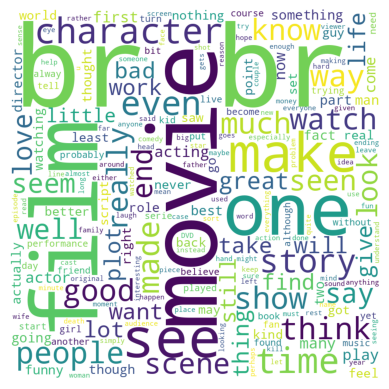

In [47]:
import os
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# ... (your other import statements)

# Load the dataset
data = pd.read_csv('/content/IMDB Dataset.csv') # Make sure this path is correct

# Now you can use 'data' in your wordcloud generation
words = ' '.join(data['review'].values)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()